In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Load Data

In [2]:
# Read in the CSV file
df = pd.read_csv("candy-data.csv")
df

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


# Data Exploration

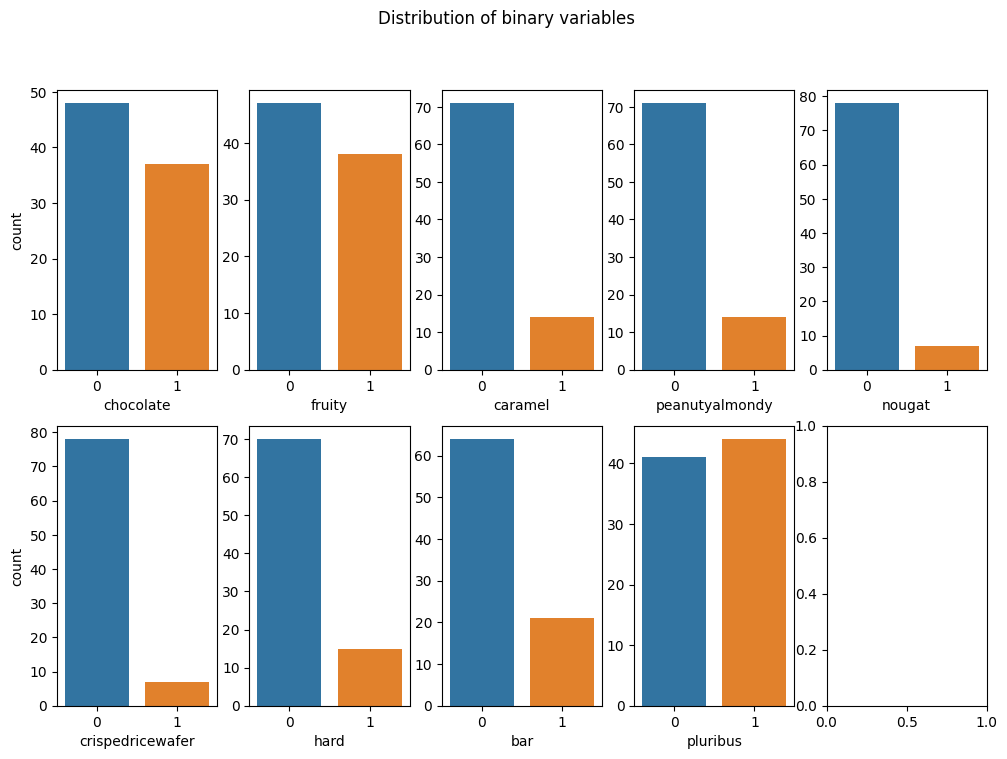

In [3]:
# Create a figure with multiple subplots
num_cols = len(df.columns) - 1
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))

# Iterate over the columns and create a histogram for each
for i, col in enumerate(["chocolate","fruity","caramel","peanutyalmondy", "nougat", "crispedricewafer", "hard","bar","pluribus"]):
    if i not in [0, 5]:
        sns.countplot(data=df, x=col, ax=ax[i//5][i%5]).set_ylabel("")
    else:
        sns.countplot(data=df, x=col, ax=ax[i//5][i%5])

# Show the plot
plt.suptitle('Distribution of binary variables')
plt.show()

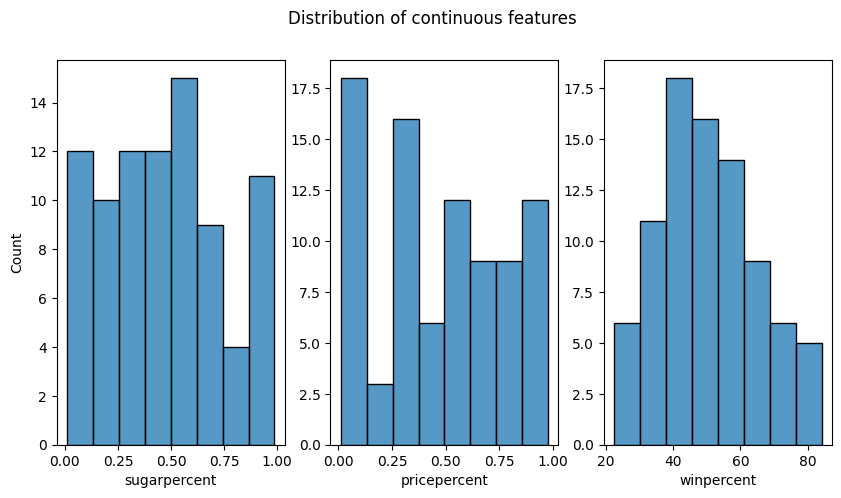

In [4]:
# Create a figure with multiple subplots
num_cols = len(df.columns) - 1
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# Iterate over the columns and create a histogram for each
for i, col in enumerate(["sugarpercent", "pricepercent", "winpercent"]):
    if i not in [0]:
        sns.histplot(data=df, x=col, ax=ax[i]).set_ylabel("")
    else:
        sns.histplot(data=df, x=col, ax=ax[i])

# Show the plot
plt.suptitle('Distribution of continuous features')
plt.show()

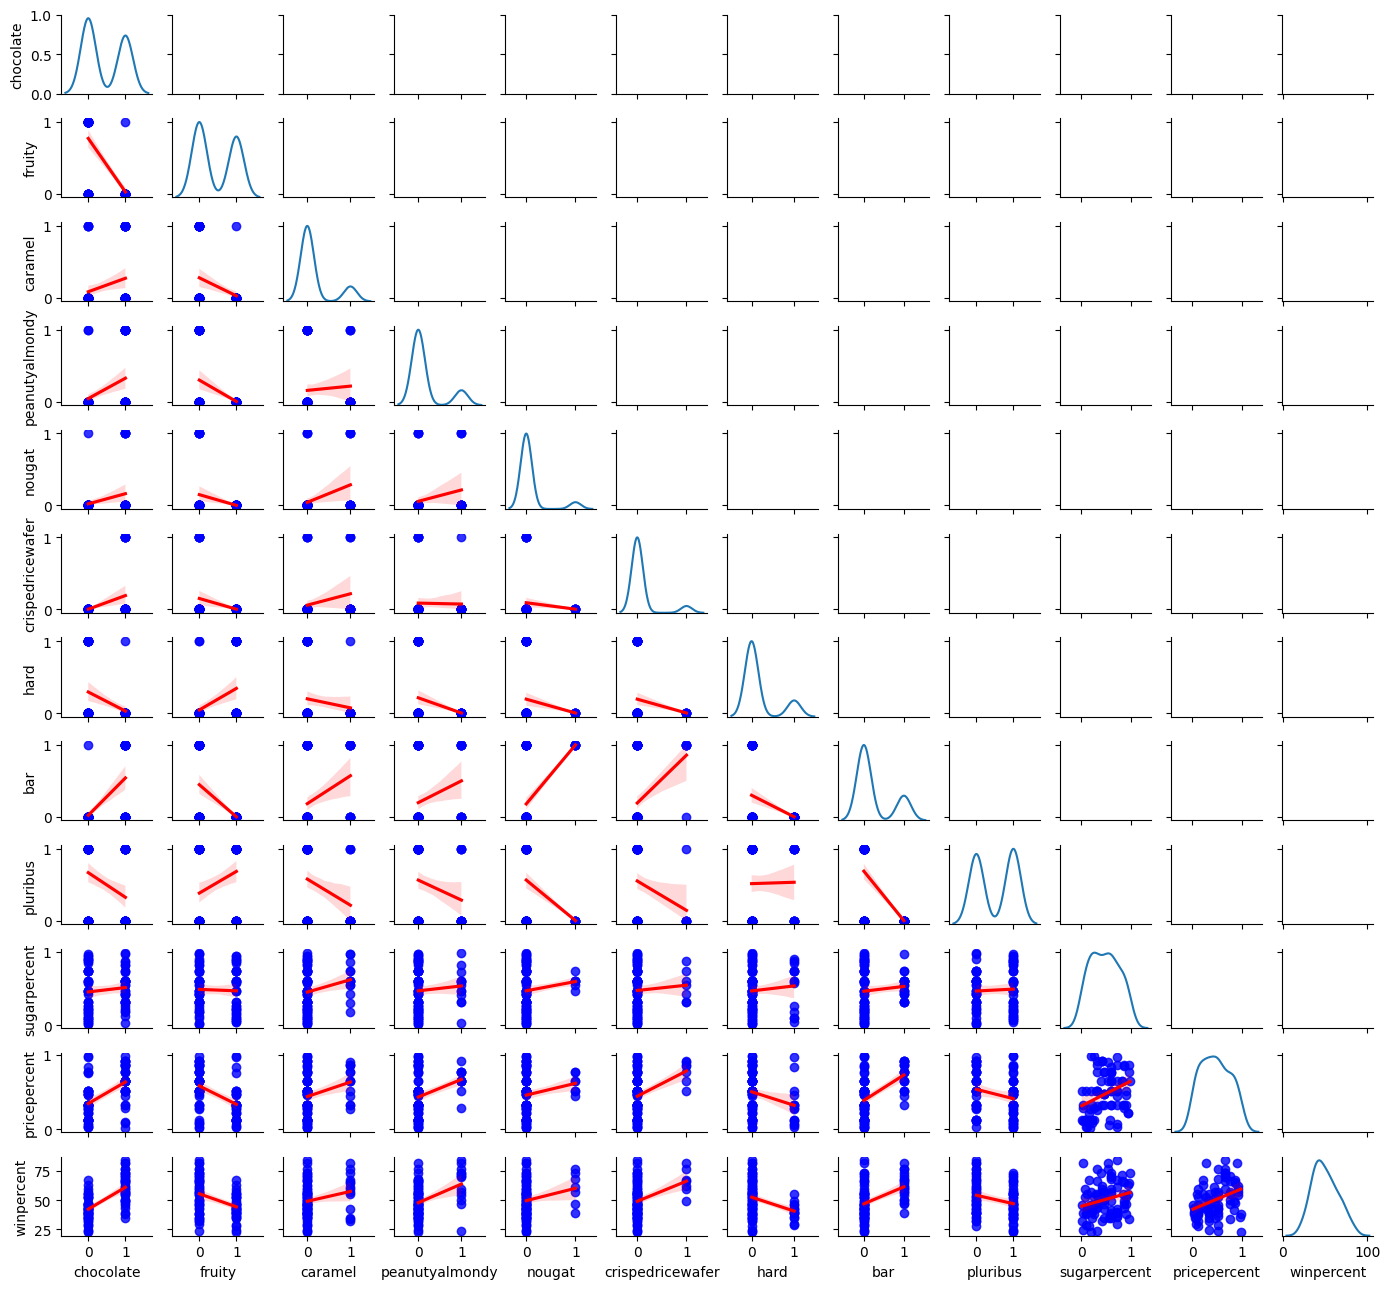

In [5]:
#Draw a Bivariate Seaborn Pairgrid and KDE density
def snsPairGrid(df):
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14, 13)
    g.map_lower(sns.regplot, color='b', scatter_kws={"color": "blue"}, line_kws={"color": "red"}) # scattered plot on lower half
    
    g.map_diag(sns.kdeplot) # draw kde approximation on the diagonal
    #g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10)
    plt.tight_layout()
    
snsPairGrid(df)

C:\Users\johan\AppData\Local\Temp\ipykernel_19752\1041701305.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = df.corr(method="pearson").round(2)


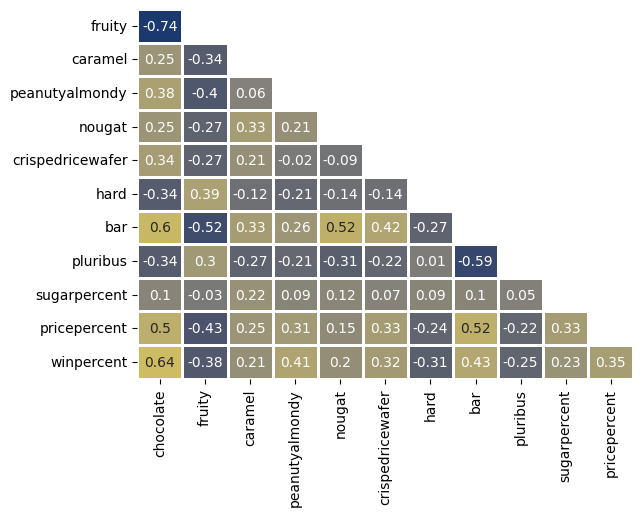

In [6]:
corr_mat = df.corr(method="pearson").round(2)
mask = np.triu(np.ones_like(corr_mat))
mask = mask[1:,:-1]
corr_mat = corr_mat.iloc[1:,:-1].copy()
sns.heatmap(corr_mat, mask=mask, vmin=-1,vmax=1,center=0, 
                cmap='cividis',square=False,lw=2,annot=True,cbar=False)
plt.show() 

# Find important Features using Random Forest and Lasso Regression

## Prepare Data for modeling

The way the data was gathered (using an online-survey, showing pictures of pairs of candies, the participants probably did not care about the price, since they didnt have to pay it. So we wont take the price into account. 

In [7]:
X = df.drop(['competitorname','winpercent','pricepercent'], axis=1) #independent columns
y = df['winpercent']   #target column 

# Scale data
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and test sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

## Modeling

Test different models. The best one will be used to represent our data. Also the random forest classifier and lasse regression are used to display feature importance.

#### Random Forest Classifier

C:\Users\johan\AppData\Local\Temp\ipykernel_19752\4180665064.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfg.fit(X_train_scaled, y_train_scaled)


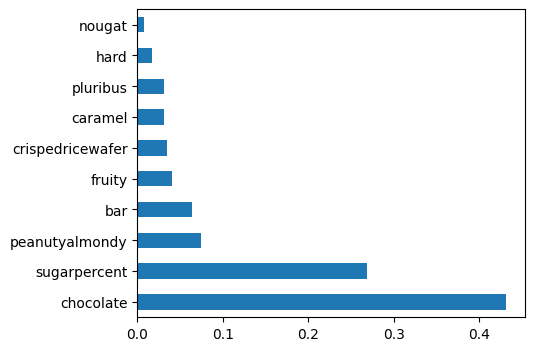

In [8]:
# Train the classifier
rfg = RandomForestRegressor(n_estimators=100)
rfg.fit(X_train_scaled, y_train_scaled)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(rfg.feature_importances_, index=X.columns)
plt.figure(figsize=(5,4))
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [9]:
# Make predictions on the train set
y_pred_train = rfg.predict(X_train_scaled)
# Make predictions on the test set
y_pred_test = rfg.predict(X_test_scaled)

In [10]:
def evaluate(model, y_pred_train, y_pred_test):
    r2_train = model.score(X_train_scaled, y_train_scaled)
    r2_test = model.score(X_test_scaled, y_test_scaled)
    mse_train = mean_squared_error(y_scaler.inverse_transform(y_train_scaled), y_scaler.inverse_transform(y_pred_train.reshape(-1, 1)))
    mse_test = mean_squared_error(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(y_pred_test.reshape(-1, 1)))

    print(f'R^2: train: {r2_train:.2f}, test: {r2_test:.2f}')
    print(f'MSE: train: {mse_train:.2f}, test: {mse_test:.2f}')

In [11]:
evaluate(rfg, y_pred_train, y_pred_test)

R^2: train: 0.91, test: 0.22
MSE: train: 18.49, test: 155.90


#### Lasso Linear Regression

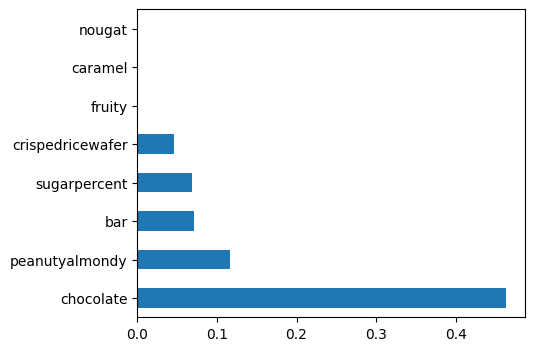

In [12]:
# Fit the linear regression model
llg = Lasso(alpha=0.1)
llg.fit(X_train_scaled, y_train_scaled)
y_pred_train = llg.predict(X_train_scaled)  
y_pred_test = llg.predict(X_test_scaled) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(llg.coef_, index=X.columns)
plt.figure(figsize=(5,4))
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

In [13]:
evaluate(llg, y_pred_train, y_pred_test)

R^2: train: 0.51, test: 0.21
MSE: train: 106.36, test: 157.67


#### Linear Regression

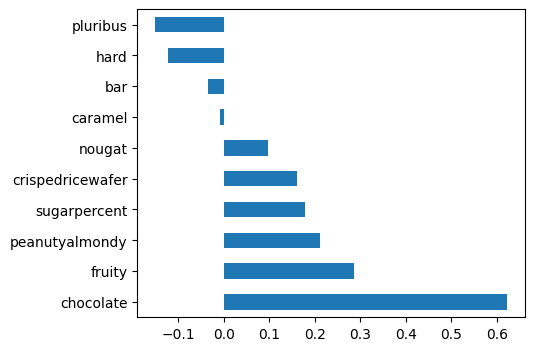

In [14]:
# Fit the linear regression model
lg = LinearRegression()
lg.fit(X_train_scaled, y_train_scaled)
y_pred_train = lg.predict(X_train_scaled)  
y_pred_test = lg.predict(X_test_scaled) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(lg.coef_[0], index=X.columns)
plt.figure(figsize=(5,4))
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [15]:
evaluate(lg, y_pred_train, y_pred_test)

R^2: train: 0.59, test: 0.17
MSE: train: 88.41, test: 166.77


# Fit linear regression model

In [73]:
X_ols = sm.add_constant(X)
ols = sm.OLS(y, X_ols)
ols_result = ols.fit()
summary = ols_result.summary(alpha=0.1)

In [74]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:             winpercent   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     8.443
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           5.25e-09
Time:                        08:59:00   Log-Likelihood:                -316.30
No. Observations:                  85   AIC:                             654.6
Df Residuals:                      74   BIC:                             681.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|       [0.05       0.95]
------------------------------------------------------------------------------------
const               33.2617      4.159  

In [59]:
results_as_html = summary.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df.drop(['std err', 't'], axis=1, inplace=True)
results_df.index.name = "property"
results_df= results_df.reset_index()
results_df = results_df[1:]


In [60]:
results_df.sort_values('P>|t|')

,property,coef,P>|t|,[0.05,0.95]
1,chocolate,19.2157,0.000,12.767,25.664
4,peanutyalmondy,9.4544,0.010,3.501,15.408
2,fruity,9.5867,0.013,3.317,15.856
7,hard,-5.8657,0.093,-11.608,-0.123
10,sugarpercent,7.4905,0.094,0.126,14.855
6,crispedricewafer,8.6367,0.105,-0.136,17.410
3,caramel,1.9820,0.589,-4.105,8.069
9,pluribus,-1.1467,0.706,-6.196,3.902
5,nougat,1.9180,0.734,-7.456,11.292
8,bar,-1.2333,0.799,-9.263,6.796


Take only candy with chocolate into account:

In [65]:
X_only_chocolate = X.loc[X["chocolate"] == 1]
y_only_chocolate = y.loc[X["chocolate"] == 1]
X_ols_choc = sm.add_constant(X_only_chocolate)
ols_choc = sm.OLS(y_only_chocolate, X_ols_choc)
ols_choc_result = ols_choc.fit()
summary = ols_choc_result.summary(alpha=0.1)

In [66]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:             winpercent   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     2.110
Date:                Tue, 10 Jan 2023   Prob (F-statistic):             0.0689
Time:                        08:58:20   Log-Likelihood:                -137.63
No. Observations:                  37   AIC:                             293.3
Df Residuals:                      28   BIC:                             307.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|       [0.05       0.95]
------------------------------------------------------------------------------------
chocolate           58.6417      7.684  

In [67]:
results_as_html = summary.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df.drop(['std err', 't'], axis=1, inplace=True)
results_df.index.name = "property"
results_df= results_df.reset_index()
results_df = results_df[1:]


In [38]:
results_df.sort_values('P>|t|')

,property,coef,P>|t|,[0.05,0.95]
3,peanutyalmondy,9.8233,0.034,2.329,17.318
8,pluribus,-9.9338,0.168,-21.866,1.998
5,crispedricewafer,8.0873,0.171,-1.708,17.882
7,bar,-8.8343,0.229,-21.048,3.380
1,fruity,-7.4699,0.271,-18.784,3.844
6,hard,-7.4699,0.271,-18.784,3.844
2,caramel,5.2984,0.308,-3.390,13.987
9,sugarpercent,8.7427,0.323,-6.048,23.534
4,nougat,0.3477,0.958,-10.824,11.519


#### Examples

In [93]:
example = df.loc[(df["chocolate"] == 1) & (df["peanutyalmondy"] == 1) & (df["crispedricewafer"] == 1) & (df["caramel"] == 1) & (df["fruity"] == 0) & (df["pluribus"] == 0)& (df["hard"] == 0)]

In [94]:
example = example.drop(['competitorname','winpercent','pricepercent'], axis=1)

In [95]:
example

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent
65,1,0,1,1,0,1,0,1,0,0.604


In [96]:
example = sm.add_constant(example, has_constant='add')

In [97]:
example

,const,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent
65,1.0,1,0,1,1,0,1,0,1,0,0.604


In [98]:
ols_result.predict(example)

65    75.841562
dtype: float64

In [101]:
#remove bar
example["bar"]=0

In [102]:
ols_result.predict(example)

65    77.074834
dtype: float64